<h1>MPII Pose Estimation</h1>

<h4>Modules</h4>

In [1]:
import scipy.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import os
import json

2024-07-24 13:47:12.167974: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h4>Data Importing</h4>

In [2]:
# load the annotations file
mat = scipy.io.loadmat('./mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')
data = mat['RELEASE']

# parse the annotations
annolist = data['annolist'][0, 0]

# extract image filenames
image_filenames = [annolist['image'][0, i]['name'][0, 0][0] for i in range(len(annolist['image'][0]))]
print(f"First 5 image filenames: {image_filenames[:5]}")

# prepare the list of complete image paths
images = ['./images/' + filename for filename in image_filenames]

# Function to load an image
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Image at {image_path} not found.")
    return image

# function to parse keypoints
def parse_keypoints(keypoints):
    parsed_keypoints = []
    if keypoints is not None and 'annopoints' in keypoints.dtype.names:
        for person in keypoints['annopoints']:
            if person.size > 0 and 'point' in person[0].dtype.names:
                person_keypoints = person[0]['point'][0]
                for point in person_keypoints:
                    x = point['x'][0, 0] if 'x' in point.dtype.names else None
                    y = point['y'][0, 0] if 'y' in point.dtype.names else None
                    if x is not None and y is not None:
                        parsed_keypoints.append((x.item(), y.item()))  # Ensure single values are extracted
    return parsed_keypoints

# create output directory if it doesn't exist
output_dir = './output_images/'
os.makedirs(output_dir, exist_ok=True)

# function to save visualized images
def save_keypoint_image(image, keypoints, filename, output_dir):
    for x, y in keypoints:
        cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
        cv2.putText(image, f"({int(x)}, {int(y)})", (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, image)
    print(f"Saved keypoint image to {output_path}")

# process and save keypoints for all images
images_with_keypoints = []
keypoints_data = {}

for i in range(len(image_filenames)):
    image_path = './images/' + image_filenames[i]
    print(f"Processing image: {image_path}")
    image = load_image(image_path)
    if image is not None:
        try:
            keypoints = annolist['annorect'][0][i]
            if keypoints is None:
                print(f"No keypoints data available for image {image_filenames[i]}.")
                continue
            
            person_keypoints = parse_keypoints(keypoints)
            if person_keypoints:
                images_with_keypoints.append(image_filenames[i])
                keypoints_data[image_filenames[i]] = person_keypoints
                save_keypoint_image(image, person_keypoints, image_filenames[i], output_dir)
            else:
                print(f"No keypoints found for image {image_filenames[i]}.")
        except Exception as e:
            print(f"Error processing keypoints for image {image_filenames[i]}: {e}")
    else:
        print(f"Skipping image {image_filenames[i]} due to loading error.")

# save the keypoints data to a JSON file
output_keypoints_file = './keypoints_data.json'
with open(output_keypoints_file, 'w') as f:
    json.dump(keypoints_data, f)
print(f"Keypoints data saved to {output_keypoints_file}")

First 5 image filenames: ['037454012.jpg', '095071431.jpg', '073199394.jpg', '059865848.jpg', '015601864.jpg']
Processing image: ./images/037454012.jpg
No keypoints found for image 037454012.jpg.
Processing image: ./images/095071431.jpg
No keypoints found for image 095071431.jpg.
Processing image: ./images/073199394.jpg
No keypoints found for image 073199394.jpg.
Processing image: ./images/059865848.jpg
No keypoints found for image 059865848.jpg.
Processing image: ./images/015601864.jpg
Saved keypoint image to ./output_images/015601864.jpg
Processing image: ./images/015599452.jpg
Saved keypoint image to ./output_images/015599452.jpg
Processing image: ./images/005808361.jpg
Saved keypoint image to ./output_images/005808361.jpg
Processing image: ./images/086617615.jpg
Saved keypoint image to ./output_images/086617615.jpg
Processing image: ./images/060111501.jpg
Saved keypoint image to ./output_images/060111501.jpg
Processing image: ./images/070807258.jpg
Saved keypoint image to ./output_

[ WARN:0@12.901] global loadsave.cpp:241 findDecoder imread_('./images/040348287.jpg'): can't open/read file: check file path/integrity
[ WARN:0@12.901] global loadsave.cpp:241 findDecoder imread_('./images/013401523.jpg'): can't open/read file: check file path/integrity
[ WARN:0@12.902] global loadsave.cpp:241 findDecoder imread_('./images/002878268.jpg'): can't open/read file: check file path/integrity


Error processing keypoints for image 070407977.jpg: argument of type 'NoneType' is not iterable
Processing image: ./images/021296416.jpg
Saved keypoint image to ./output_images/021296416.jpg
Processing image: ./images/013637148.jpg
Saved keypoint image to ./output_images/013637148.jpg
Processing image: ./images/001454467.jpg
Saved keypoint image to ./output_images/001454467.jpg
Processing image: ./images/035058756.jpg
Error processing keypoints for image 035058756.jpg: argument of type 'NoneType' is not iterable
Processing image: ./images/058991769.jpg
Saved keypoint image to ./output_images/058991769.jpg
Processing image: ./images/039224405.jpg
Saved keypoint image to ./output_images/039224405.jpg
Processing image: ./images/043747492.jpg
Saved keypoint image to ./output_images/043747492.jpg
Processing image: ./images/090415869.jpg
No keypoints found for image 090415869.jpg.
Processing image: ./images/034825547.jpg
No keypoints found for image 034825547.jpg.
Processing image: ./images/

In [3]:
images_with_keypoints[10]


'030424224.jpg'

In [4]:
keypoints_data['030424224.jpg']

[(324, 265)]

Image path: ./images/092187424.jpg


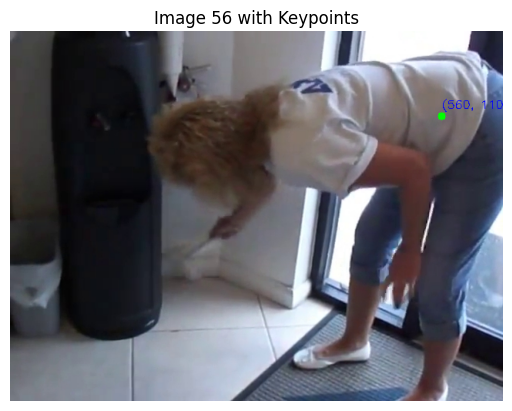

In [5]:
def visualize_keypoints(image, keypoints, title="Image with Keypoints"):
    for x, y in keypoints:
        cv2.circle(image, (int(x), int(y)), 5, (0, 255, 0), -1)
        cv2.putText(image, f"({int(x)}, {int(y)})", (int(x), int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

index = 55 
image_path = './images/' + image_filenames[index]
print(f"Image path: {image_path}")
image = load_image(image_path)
if image is not None:
    person_keypoints = parse_keypoints(annolist['annorect'][0][index])
    visualize_keypoints(image, person_keypoints, title=f"Image {index + 1} with Keypoints")

In [6]:
keypoints_data['092187424.jpg']

[(560, 110)]

<h4>Data Preparation</h4>

In [7]:
# create image paths and keypoints lists
image_paths = ['./images/' + filename for filename in images_with_keypoints]
keypoints_list = [keypoints_data[filename] for filename in images_with_keypoints]

# split data into training and validation sets
split_index = int(0.8 * len(image_paths))
train_image_paths = image_paths[:split_index]
val_image_paths = image_paths[split_index:]
train_keypoints = keypoints_list[:split_index]
val_keypoints = keypoints_list[split_index:]

# debugging statements to check lengths
print(f"Length of train_image_paths: {len(train_image_paths)}")
print(f"Length of train_keypoints: {len(train_keypoints)}")
print(f"Length of val_image_paths: {len(val_image_paths)}")
print(f"Length of val_keypoints: {len(val_keypoints)}")

# check if any of the lists are empty
if len(train_image_paths) == 0 or len(train_keypoints) == 0 or len(val_image_paths) == 0 or len(val_keypoints) == 0:
    raise ValueError("One of the lists (train or validation) is empty. Please check your data splitting.") 
image_paths = ['./images/' + filename for filename in images_with_keypoints]
keypoints_list = [keypoints_data[filename] for filename in images_with_keypoints]


Length of train_image_paths: 13897
Length of train_keypoints: 13897
Length of val_image_paths: 3475
Length of val_keypoints: 3475


In [8]:
def load_images(image_paths, target_size):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)  
        img_array = img_to_array(img)  
        img_array = img_array / 255.0  
        images.append(img_array)
    return np.array(images)

# define target image size
target_size = (128, 128)  
train_images = load_images(train_image_paths, target_size)
val_images = load_images(val_image_paths, target_size)

In [53]:
val_image_paths[:3]

['./images/076524332.jpg', './images/073085177.jpg', './images/017286052.jpg']

In [9]:
def normalize_keypoints(keypoints, image_size):
    normalized_keypoints = []
    for kp in keypoints:
        normalized_kp = [(x / image_size[1], y / image_size[0]) for x, y in kp]
        normalized_keypoints.append(normalized_kp)
    return np.array(normalized_keypoints)

# normalize keypoints
train_keypoints_new = normalize_keypoints(train_keypoints, target_size)
val_keypoints_new = normalize_keypoints(val_keypoints, target_size)

In [10]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

<h4>Model training</h4>

In [11]:
def create_model(input_shape, num_keypoints, learning_rate):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(num_keypoints * 2, kernel_regularizer=regularizers.l2(0.01)))  # Each keypoint has (x, y) coordinates
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# define constants
input_shape = (target_size[0], target_size[1], 3)
num_keypoints = len(train_keypoints_new[0]) 

# create the model
model = create_model(input_shape, num_keypoints, learning_rate=0.001)


/home/marius/Desktop/Coding/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-24 13:53:11.044270: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-24 13:53:11.088028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentatio

In [12]:
datagen.fit(train_images)

In [13]:
# define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# train the model with data augmentation and learning rate scheduling
history = model.fit(datagen.flow(train_images, train_keypoints_new),
                                        epochs=10,
                                        validation_data=(val_images, val_keypoints_new),
                                        callbacks=[reduce_lr, early_stopping])

Epoch 1/10


/home/marius/Desktop/Coding/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721818397.037815    4784 service.cc:145] XLA service 0x756ad80042d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721818397.037868    4784 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-24 13:53:17.126494: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-24 13:53:17.495386: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN versi

  4/435 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - loss: 38.5825 - mean_squared_error: 22.3758

I0000 00:00:1721818403.052727    4784 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


432/435 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 27.4454 - mean_squared_error: 14.2893

2024-07-24 13:53:54.420545: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 683212800 exceeds 10% of free system memory.
2024-07-24 13:53:55.095102: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 683212800 exceeds 10% of free system memory.


435/435 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - loss: 27.3667 - mean_squared_error: 14.2416 - val_loss: 9.4945 - val_mean_squared_error: 4.7394 - learning_rate: 0.0010
Epoch 2/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - loss: 8.9902 - mean_squared_error: 5.1004 - val_loss: 7.6655 - val_mean_squared_error: 5.5357 - learning_rate: 0.0010
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - loss: 6.5766 - mean_squared_error: 4.7372 - val_loss: 6.0984 - val_mean_squared_error: 4.8350 - learning_rate: 0.0010
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - loss: 5.7277 - mean_squared_error: 4.6124 - val_loss: 5.2836 - val_mean_squared_error: 4.6311 - learning_rate: 0.0010
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 28s 64ms/step - loss: 5.1656 - mean_squared_error: 4.5729 - val_loss: 5.0147 - val_mean_squared_error: 4.6645 - learning_rate: 0.0010
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - loss: 4.7955 - mean_squared_error: 4.4819 - val_loss: 4.9034 - val_mean_squared_err

<h4>Model evaluation </h4>

In [15]:
# evaluate the model
val_loss = model.evaluate(val_images, val_keypoints_new)
print(f'Validation Loss: {val_loss}')

2024-07-24 13:58:13.981936: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 683212800 exceeds 10% of free system memory.
2024-07-24 13:58:14.658293: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 683212800 exceeds 10% of free system memory.


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.8238 - mean_squared_error: 4.6578
Validation Loss: [4.669072151184082, 4.503072738647461]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
True Keypoints:
[[6.0625 2.25  ]]
Predicted Keypoints:
[[5.149162 3.665131]]


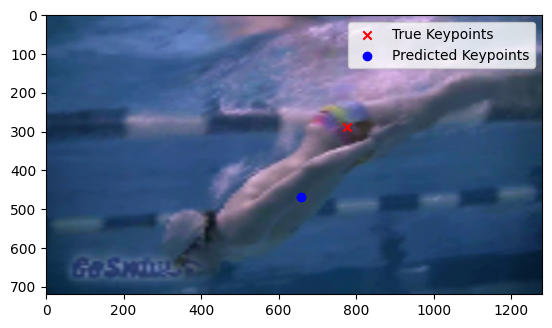

True Keypoints:
[[4.9140625 2.21875  ]]
Predicted Keypoints:
[[5.184092 3.685705]]


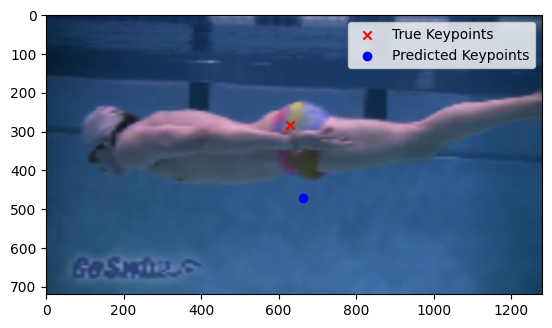

True Keypoints:
[[5.1875   3.015625]]
Predicted Keypoints:
[[5.1913977 3.68981  ]]


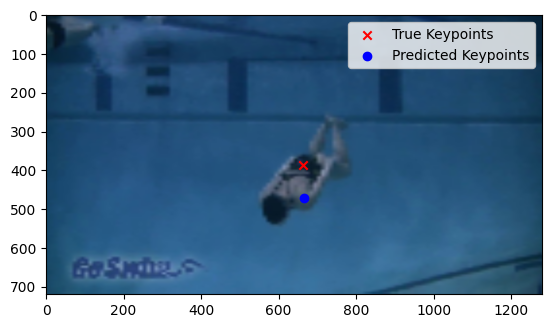

In [52]:
# function to resize the image to a specific size
def resize_image(image, target_size):
    return resize(image, target_size, mode='reflect', anti_aliasing=True)

# function to plot images with keypoints
def plot_keypoints(image, keypoints, predicted_keypoints=None):
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    # plot true keypoints
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='r', marker='x', label='True Keypoints')
    
    # plot predicted keypoints if available
    if predicted_keypoints is not None:
        ax.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], c='b', marker='o', label='Predicted Keypoints')
    
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)  #
    ax.legend()
    plt.show()

# define target size for image resizing
target_size = (720, 1280)  # (height, width)

# get the batch of images and keypoints
val_images_batch = val_images[:3]
val_keypoints_batch = val_keypoints_new[:3]

# make predictions
predicted_keypoints = model.predict(val_images_batch)

# plot some validation images with true and predicted keypoints
for i in range(len(val_images_batch)):
    image = val_images_batch[i]
    true_keypoints = val_keypoints_batch[i].reshape(-1, 2)
    pred_keypoints = predicted_keypoints[i].reshape(-1, 2)
    
    # resize the image to the target size
    resized_image = resize_image(image, target_size)
    
    # directly use the keypoints if they are in pixel coordinates
    image_size = (target_size[1], target_size[0])  # width, height
    # no denormalization required if keypoints are already in pixel coordinates
    
    # debug print to check keypoints values
    print("True Keypoints:")
    print(true_keypoints)
    print("Predicted Keypoints:")
    print(pred_keypoints)
    
    # plotting the keypoints
    plot_keypoints(resized_image, true_keypoints * 128, pred_keypoints * 128)